In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36266")
client

Client Scheduler: tcp://127.0.0.1:36266 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 60 Memory: 254.00 GB


In [1]:
import numpy as np
import xarray as xr
import gsw
import time
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import scipy.sparse as spar
import scipy.signal as spsig
import scipy.ndimage as spimg
import dask_image.ndfilters as dsfilt
import dask.array as dsar
import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [3]:
grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50
sstart = 12
send = 35
nremap = 50
dnf = 2160
nchk = 30
nskip = 3

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
# for nmemb in range(24,36):
#     if nmemb == 24:
#         ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                      % (nmemb,year)), 
#                              grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                              iters=943920,
#                              prefix=['diag_ocnSnap'], delta_t=2e2,
#                             ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                  ).chunk({'XC':xchunk,'XG':xchunk,
#                                           'YC':ychunk,'YG':ychunk})
#     else:
#         ds = xr.concat([ds, open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                                     % (nmemb,year)), 
#                                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                                             iters=943920,
#                                             prefix=['diag_ocnSnap'], delta_t=2e2,
#                                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                                 ).chunk({'XC':xchunk,'XG':xchunk,
#                                                          'YC':ychunk,'YG':ychunk})],
#                        dim='nmemb')
# ds = ds.isel(time=slice(-len(dsmn.time),None))
# pot_rho = xr.apply_ufunc(jmd95.densjmd95, ds.SALT.mean('nmemb'), ds.THETA.mean('nmemb'),
#                          0., # pressure in [dbar]!!!!
#                          dask='parallelized', output_dtypes=[float,]
#                         ).where(ds.maskC!=0.)
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (24,1963)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=1103760,
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1),
                          YG=slice(ySstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 2.208e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) >f4 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1      (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu       (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl       (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAz      (YG, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    drC      (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF   (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
dsmn = xr.open_dataset(op.join(ddir,'%4d/Dyn_membs_0000943920.nc' % (year))
#                        concat_dim='time', parallel=True
                      ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
                               'XC':xchunk,'XG':xchunk,
                               'YC':ychunk,'YG':ychunk})
dsz = xr.open_dataset(op.join(ddir,'%4d/Zs_membs_0000943920.nc' % (year))
#                       concat_dim='time', parallel=True
                     ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
                              'XC':xchunk,'XG':xchunk,
                              'YC':ychunk,'YG':ychunk})
dsep = xr.open_dataset(op.join(ddir,'%4d/E-P_flux_0000943920.nc' % (year))
                      ).chunk({'sig':schunk,'sigp1':schunk,
                               'XC':xchunk,'XG':xchunk,
                               'YC':ychunk,'YG':ychunk})
dsdiv = xr.open_dataset(op.join(ddir,'%4d/divE-P_flux_0000943920.nc' % (year))
                       ).chunk({'sig':schunk,'sigp1':schunk,
                                'XC':xchunk,'XG':xchunk,
                                'YC':ychunk,'YG':ychunk})
# dsmn.coords['time'] = ('time',dsraw.time.data[:len(dsmn.time)])
# dsmn.coords['time'] = ('time',ds.time.data)
# dsz.coords['time'] = ('time',ds.time.data)
grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'sig','outer':'sigp1'},
                   'Y':{'center':'YC','left':'YG'},
                   'X':{'center':'XC','left':'XG'}}
           )

dsmn

FileNotFoundError: [Errno 2] No such file or directory: b'/tank/topog/tuchida/TWA/1964/Dyn_membs_0000943920.nc'

In [ ]:
fC = xr.apply_ufunc(gsw.f, dsz.YC)
fG = xr.apply_ufunc(gsw.f, dsz.YG)
buoyb = -grav * dsmn.sig * rhoConst**-1
buoybp1 = -grav * dsmn.sigp1 * rhoConst**-1
sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

zetab = (dsz.zdz*dsz.dzetaF**-1).mean('nmemb',skipna=True)
zetaxb = (dsz.zxdz*dsz.dzetaFx**-1).mean('nmemb',skipna=True)
zetayb = (dsz.zydz*dsz.dzetaFy**-1).mean('nmemb',skipna=True)
# sigmab = grid.interp(grid.diff(zetab,'Z',boundary='fill') 
#                      * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                      'Z',boundary='fill')
# sigmazb = (grid.diff(zetab,'Z',boundary='fill') 
#            * grid.diff(buoyb,'Z',boundary='fill')**-1)
# sigmayb = grid.interp(grid.diff(zetayb,'Z',boundary='fill') 
#                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                       'Z',boundary='fill')
# sigmaxb = grid.interp(grid.diff(zetaxb,'Z',boundary='fill') 
#                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                       'Z',boundary='fill')
sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
          * -grid.diff(buoybp1,'Z',boundary='fill')**-1
         )
sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmazb = (dsz.dzetaFz.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
    
# vhat = ((dsmn.vdz * -grid.diff(buoybp1,'Z',boundary='fill'
#                               )**-1 # vdz * db**-1 = v * dz/db = v * \sigma
#         ).mean('nmemb',skipna=True)
#         * sigmayb**-1
#        )
# uhat = ((dsmn.udz * -grid.diff(buoybp1,'Z',boundary='fill')**-1
#         ).mean('nmemb',skipna=True)
#         * sigmaxb**-1
#        )
vhat = dsmn.vdz.mean('nmemb',skipna=True) * dsz.dzetaFy.mean('nmemb',skipna=True)**-1
uhat = dsmn.udz.mean('nmemb',skipna=True) * dsz.dzetaFx.mean('nmemb',skipna=True)**-1
KE = .5*(grid.interp(uhat**2,'X') 
         + grid.interp(vhat**2,'Y',boundary='fill')
        )
Ro = (grid.diff(vhat*ds.dyC,'X') 
      - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
     ) * ds.rAz**-1 * fG**-1
KE

In [ ]:
vort = (grid.diff(vhat*ds.dyC,'X') 
        - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1
Pi = ((grid.interp(grid.interp(vort,'X'),'Y',boundary='fill') 
       + fC) * sigmab**-1)
Pi_f = (1. + grid.interp(grid.interp(vort,'X'),
                         'Y',boundary='fill') * fC**-1
       ) * sigmab**-1
Pi_f

In [ ]:
# varpihat = ((dsmn.varpi * sigma).mean('nmemb',skipna=True) 
#             * sigmab**-1)
varpihat = ((dsmn.varpidz_db * -grid.diff(buoybp1,'Z',boundary='fill')
            ).mean('nmemb',skipna=True) 
            * dsz.dzetaF.mean('nmemb',skipna=True)**-1)

vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
varpipp = (dsmn.varpidz_db*dsz.dzetaF**-1
           * -grid.diff(buoybp1,'Z',boundary='fill') - varpihat)

zetap = (dsz.zdz*dsz.dzetaF**-1 - zetab) 
zetayp = (dsz.zydz*dsz.dzetaFy**-1 - zetayb)
zetaxp = (dsz.zxdz*dsz.dzetaFx**-1 - zetaxb)

mbx = dsmn.pxdz * dsz.dzetaFx**-1
mby = dsmn.pydz * dsz.dzetaFy**-1
mbxp = mbx - mbx.mean('nmemb',skipna=True)
mbyp = mby - mby.mean('nmemb',skipna=True)

tmp00 = ((upp**2*sigmax)
         + .5*(zetaxp**2)
        ).mean('nmemb',skipna=True)
tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
         * upp*sigmax).mean('nmemb',skipna=True)
tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
         * vpp*sigmay).mean('nmemb',skipna=True)
tmp11 = ((vpp**2*sigmay) 
         + .5*(zetayp**2)
        ).mean('nmemb',skipna=True)
tmp20 = ((varpipp*grid.interp(upp,'X')*sigma)
         + grid.interp(mbxp*zetaxp,'X')
        ).mean('nmemb',skipna=True)
tmp21 = ((varpipp*grid.interp(vpp,'Y',boundary='fill')*sigma)
         + grid.interp(mbyp*zetayp,'Y',boundary='fill')
        ).mean('nmemb',skipna=True)
tmp00_0 = (upp**2*sigmax).mean('nmemb',skipna=True)
tmp00_1 = .5*(zetaxp**2).mean('nmemb',skipna=True)
tmp11_0 = (vpp**2*sigmay).mean('nmemb',skipna=True)
tmp11_1 = .5*(zetayp**2).mean('nmemb',skipna=True)

In [ ]:
e00 = dsep.e00
e10 = dsep.e10
e20 = dsep.e20
e01 = dsep.e01
e11 = dsep.e11
e21 = dsep.e21

e00_x = dsdiv.e00x
e10_y = dsdiv.e10y
e20_b = dsdiv.e20b
e01_x = dsdiv.e01x
e11_y = dsdiv.e11y
e21_b = dsdiv.e21b

Eu = e00_x + e10_y + e20_b
Ev = e01_x + e11_y + e21_b
PVpx = sigmab**-1 * Ev
PVpy = -sigmab**-1 * Eu

In [6]:
def _filt(da, area=None, dim=['YC','XC'], nker=5, cutoff=3):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    return da_LS

####################
ny, nx, nb = (3,3,1)
def med_filt(da, nker=np.ones((ny,nx,nb))):
#     if area is not None:
#         da = da*area
    return xr.DataArray(dsfilt.median_filter(da.data, footprint=nker), 
                        dims=da.dims, coords=da.coords)

In [ ]:
(xr.DataArray(dsfilt.median_filter(vort.drop_vars('rAz').chunk({'YG':ychunk,
                                                                'XG':xchunk}
                                                              ).isel(sig=16).data, 
                                   footprint=np.ones((3,5))), 
              dims=vort.isel(sig=16).dims,
              coords=vort.isel(sig=16).coords) * fG**-1).plot(vmax=.1, vmin=-.1, 
                                                              cmap='RdBu_r')

In [ ]:
vort_sm = filt(vort.drop_vars('rAz').isel(sig=16).chunk({'YG':ychunk,
                                                         'XG':xchunk}
                                                        ), nker=np.ones((ny,nx)))
zetaxb_sm = filt(zetaxb, nker=np.ones((ny,nx,nb)))
zetayb_sm = filt(zetayb, nker=np.ones((ny,nx,nb)))
sigmab_sm = filt(sigmab.isel(sig=16), nker=np.ones((ny,nx)))


vortsm_x = grid.diff(vort_sm*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vortsm_y = grid.diff(vort_sm*grid.interp(ds.dxG,'X'),
                     'Y',boundary='fill') * ds.rAw**-1
vort_x = grid.diff(vort*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vort_y = grid.diff(vort*grid.interp(ds.dxG,'X'),
                   'Y',boundary='fill') * ds.rAw**-1


zetabsm_x = grid.diff(zetaxb_sm,'X')*grid.interp(ds.dxC,'X')**-1
zetabsm_y = (grid.diff(zetayb_sm,'Y',boundary='fill')
             * grid.interp(ds.dyC,'Y',boundary='fill')**-1)
zetab_x = grid.diff(zetaxb,'X')*grid.interp(ds.dxC,'X')**-1
zetab_y = grid.diff(zetayb,'Y',boundary='fill')*grid.interp(ds.dyC,'Y',boundary='fill')**-1


sigmabsm_x = grid.interp(grid.diff(zetabsm_x,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill').isel(sig=16)
sigmabsm_y = grid.interp(grid.diff(zetabsm_y,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill').isel(sig=16)
sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill').isel(sig=16)
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill').isel(sig=16)


absvortsm = fC + grid.interp(grid.interp(vort_sm,'X'),'Y',boundary='fill')
Pism_xs = (grid.interp(vortsm_x,'Y',boundary='fill')
           - sigmab_x * sigmab_sm**-1 * absvortsm)
Pism_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
           + grid.interp(vortsm_y,'X')
          ) - sigmab_y * sigmab_sm**-1 * absvortsm
absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
         - sigmab_x * sigmab**-1 * absvort)
Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
         + grid.interp(vort_y,'X')
        ) - sigmab_y * sigmab**-1 * absvort


Pism_x = Pism_xs * sigmab_sm**-1
Pism_y = Pism_ys * sigmab_sm**-1
Pi_x = Pi_xs * sigmab**-1
Pi_y = Pi_ys * sigmab**-1
print(Pi_y,Pi_x)

In [ ]:
that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
that_sm = filt(that.isel(sig=16), nker=np.ones((ny,nx)))
shat_sm = filt(shat.isel(sig=16), nker=np.ones((ny,nx)))


thatsm_x = grid.diff(that_sm,'X') * ds.dxC**-1
thatsm_y = grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1
shatsm_x = grid.diff(shat_sm,'X') * ds.dxC**-1
shatsm_y = grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1
that_x = grid.diff(that,'X') * ds.dxC**-1
that_y = grid.diff(that,'Y',boundary='fill') * ds.dyC**-1
shat_x = grid.diff(shat,'X') * ds.dxC**-1
shat_y = grid.diff(shat,'Y',boundary='fill') * ds.dyC**-1


tpp = dsmn.tdz * dsz.dzetaF**-1 - that
spp = dsmn.sdz * dsz.dzetaF**-1 - shat
upptpphat = (upp*grid.interp(tpp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uppspphat = (upp*grid.interp(spp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uptphat_sm = filt(upptpphat.isel(sig=16).chunk({'YC':ychunk,'XG':xchunk}), 
                  nker=np.ones((ny,nx)))
vptphat_sm = filt(vpptpphat.isel(sig=16).chunk({'YG':ychunk,'XC':xchunk}), 
                  nker=np.ones((ny,nx)))
upsphat_sm = filt(uppspphat.isel(sig=16).chunk({'YC':ychunk,'XG':xchunk}), 
                  nker=np.ones((ny,nx)))
vpsphat_sm = filt(vppspphat.isel(sig=16).chunk({'YG':ychunk,'XC':xchunk}), 
                  nker=np.ones((ny,nx)))

# print(that_x, that_y, shat_x, shat_y, upptpphat, vpptpphat)
upsphat_sm

In [ ]:
PVpx_sm = filt(PVpx.isel(sig=16), nker=np.ones((ny,nx)))
PVpy_sm = filt(PVpy.isel(sig=16), nker=np.ones((ny,nx)))

In [15]:
ut = grid.interp(uptphat_sm,
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vt = grid.interp(vptphat_sm,
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
us = grid.interp(upsphat_sm,
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vs = grid.interp(vpsphat_sm,
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
uPV = PVpx_sm.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vPV = PVpy_sm.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()

tx = grid.interp(thatsm_x,
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
ty = grid.interp(thatsm_y,
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sx = grid.interp(shatsm_x,
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sy = grid.interp(shatsm_y,
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVx = Pism_x.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVy = Pism_y.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()

KeyboardInterrupt: 

In [ ]:
ut_norm = (ut * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1)
vt_norm = (vt * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1)
us_norm = (us * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
vs_norm = (vs * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
uPV_norm = (uPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)
vPV_norm = (vPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)

tx_norm = (tx * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1)
ty_norm = (ty * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1)
sx_norm = (sx * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
sy_norm = (sy * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
PVx_norm = (PVx * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)
PVy_norm = (PVy * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)

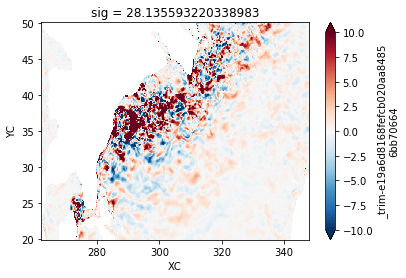

In [70]:
uPV_norm.plot(vmax=1e1)

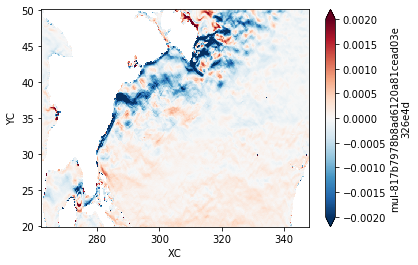

In [75]:
ty_norm.plot(vmax=0.002)

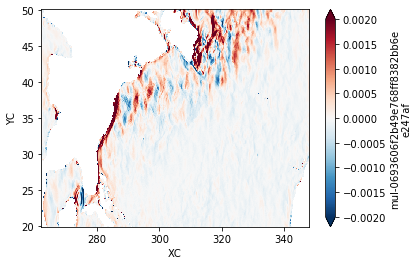

In [76]:
tx_norm.plot(vmax=0.002)

In [13]:
K = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                          len(dsz.XC),2,2))*np.nan,
                 dims=['YC','XC','col','row'],
                 coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                         'XC':dsz.XC.data}
                )
print(K.shape)

for j in range(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)))):
    if j % 20 == 0:
        print(j)
    for i in range(len(dsz.XC)):
#         for k in range(len(dsz.sig.isel(sig=slice(14,30)))):
        if i < len(dsz.XC)-1:
            k = i+1
        else:
            k = 0
        rowF  = np.array([ 0, 0, 
                           1, 1,
                           2, 2,
                           3, 3, 
                           4, 4,
                           5, 5,
                           6, 6, 
                           7, 7,
                           8, 8,
                           9, 9,
                          10,10,
                          11,11,
                          12,12,
                          13,13,
                          14,14])
        colF  = np.array([ 0, 1, 
                           0, 1, 
                           0, 1,
                           0, 1, 
                           0, 1, 
                           0, 1,
                           0, 1, 
                           0, 1, 
                           0, 1,
                           0, 1, 
                           0, 1, 
                           0, 1,
                           0, 1, 
                           0, 1, 
                           0, 1])
        dataF = np.array([ ut_norm.isel(YC=j-1,XC=i),  vt_norm.isel(YC=j-1,XC=i),
                           us_norm.isel(YC=j-1,XC=i),  vs_norm.isel(YC=j-1,XC=i),
                          uPV_norm.isel(YC=j-1,XC=i), vPV_norm.isel(YC=j-1,XC=i),
                           ut_norm.isel(YC=j,XC=i),    vt_norm.isel(YC=j,XC=i),
                           us_norm.isel(YC=j,XC=i),    vs_norm.isel(YC=j,XC=i),
                          uPV_norm.isel(YC=j,XC=i),   vPV_norm.isel(YC=j,XC=i),
                           ut_norm.isel(YC=j+1,XC=i),  vt_norm.isel(YC=j+1,XC=i),
                           us_norm.isel(YC=j+1,XC=i),  vs_norm.isel(YC=j+1,XC=i),
                          uPV_norm.isel(YC=j+1,XC=i), vPV_norm.isel(YC=j+1,XC=i),
                           ut_norm.isel(YC=j,XC=i-1),  vt_norm.isel(YC=j,XC=i-1),
                           us_norm.isel(YC=j,XC=i-1),  vs_norm.isel(YC=j,XC=i-1),
                          uPV_norm.isel(YC=j,XC=i-1), vPV_norm.isel(YC=j,XC=i-1),
                           ut_norm.isel(YC=j,XC=k),    vt_norm.isel(YC=j,XC=k),
                           us_norm.isel(YC=j,XC=k),    vs_norm.isel(YC=j,XC=k),
                          uPV_norm.isel(YC=j,XC=k),   vPV_norm.isel(YC=j,XC=k)])
        F = spar.csr_matrix((dataF, (rowF, colF)), shape=(23,2)).toarray()
#         F = np.array([[ ut_norm.isel(YC=j,XC=i),  vt_norm.isel(YC=j,XC=i)],
#                       [ us_norm.isel(YC=j,XC=i),  vs_norm.isel(YC=j,XC=i)],
#                       [uPV_norm.isel(YC=j,XC=i), vPV_norm.isel(YC=j,XC=i)]]
#                     )
        
        rowG  = np.array([ 0, 0, 1, 1, 2, 2,
                           3, 3, 4, 4, 5, 5,
                           6, 6, 7, 7, 8, 8,
                           9, 9,10,10,11,11,
                          12,12,13,13,14,14,
                          15,15,15, 
                          16,16,16,
                          17,17,17, 
                          18,18,18,
                          19,19,19, 
                          20,20,20,
                          21,21,21, 
                          22,22,22])
        colG  = np.array([ 0, 3, 0, 3, 0, 3,
                           1, 4, 1, 4, 1, 4,
                           2, 5, 2, 5, 2, 5,
                           6, 8, 6, 8, 6, 8,
                           7, 9, 7, 9, 7, 9,
                           0, 1, 2,    # A
                           3, 4, 5,    # A
                           6, 1, 7,    # B
                           8, 4, 9,    # B
                           0, 1, 2,    # A
                           3, 4, 5,    # A
                           6, 1, 7,    # B
                           8, 4, 9])   # B
        wht = 1e3   # 1e6*1e-4
        Aj_1i = wht*(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
        Aji = wht*-dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                              + dyU.isel(YC=j,XG=i)**-1
                                             )
        Aj1i = wht*(dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
        Bji_1 = wht*(dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1
        Bji = wht*-dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                            + dxV.isel(YG=j,XC=i)**-1
                                           )
        Bji1 = wht*(dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1
        dataG = np.array([ -tx_norm.isel(YC=j-1,XC=i),  -ty_norm.isel(YC=j-1,XC=i),
                           -sx_norm.isel(YC=j-1,XC=i),  -sy_norm.isel(YC=j-1,XC=i),
                          -PVx_norm.isel(YC=j-1,XC=i), -PVy_norm.isel(YC=j-1,XC=i),
                           -tx_norm.isel(YC=j,XC=i),    -ty_norm.isel(YC=j,XC=i),
                           -sx_norm.isel(YC=j,XC=i),    -sy_norm.isel(YC=j,XC=i),
                          -PVx_norm.isel(YC=j,XC=i),   -PVy_norm.isel(YC=j,XC=i),
                           -tx_norm.isel(YC=j+1,XC=i),  -ty_norm.isel(YC=j+1,XC=i),
                           -sx_norm.isel(YC=j+1,XC=i),  -sy_norm.isel(YC=j+1,XC=i),
                          -PVx_norm.isel(YC=j+1,XC=i), -PVy_norm.isel(YC=j+1,XC=i),
                           -tx_norm.isel(YC=j,XC=i-1),  -ty_norm.isel(YC=j,XC=i-1),
                           -sx_norm.isel(YC=j,XC=i-1),  -sy_norm.isel(YC=j,XC=i-1),
                          -PVx_norm.isel(YC=j,XC=i-1), -PVy_norm.isel(YC=j,XC=i-1),
                           -tx_norm.isel(YC=j,XC=k),    -ty_norm.isel(YC=j,XC=k),
                           -sx_norm.isel(YC=j,XC=k),    -sy_norm.isel(YC=j,XC=k),
                          -PVx_norm.isel(YC=j,XC=k),   -PVy_norm.isel(YC=j,XC=k),
################################                          
                           Aj_1i, Aji, Aj1i,
                           Aj_1i, Aji, Aj1i,

                           Bji_1, Bji, Bji1,
                           Bji_1, Bji, Bji1,
################################
                           Aj_1i, Aji, Aj1i,
                           Aj_1i, Aji, Aj1i,

                           Bji_1, Bji, Bji1,
                           Bji_1, Bji, Bji1])
        G = spar.csr_matrix((dataG, (rowG, colG)), shape=(23,10)).toarray()
#         G = -np.array([[ tx_norm.isel(YC=j,XC=i),  ty_norm.isel(YC=j,XC=i)],
#                        [ sx_norm.isel(YC=j,XC=i),  sy_norm.isel(YC=j,XC=i)],
#                        [PVx_norm.isel(YC=j,XC=i), PVy_norm.isel(YC=j,XC=i)]]
#                      )
        if ~(np.isnan(F).any() or np.isnan(G).any()):
            tmp = np.linalg.pinv(G).dot(F)
            K.isel(YC=j,XC=i)[0,0] = tmp[1,0]
            K.isel(YC=j,XC=i)[1,0] = tmp[4,0]
            K.isel(YC=j,XC=i)[0,1] = tmp[1,1]
            K.isel(YC=j,XC=i)[1,1] = tmp[4,1]
#             try:
#                 GT = np.transpose(G)
# #                 K.isel(YC=j,XC=i)[:] = np.linalg.inv(GT.dot(G)).dot(GT).dot(F) 
#                 tmp = np.linalg.inv(GT.dot(G)).dot(GT).dot(F)
#                 K.isel(YC=j,XC=i)[0,0] = tmp[1,0]
#                 K.isel(YC=j,XC=i)[1,0] = tmp[4,0]
#                 K.isel(YC=j,XC=i)[0,1] = tmp[1,1]
#                 K.isel(YC=j,XC=i)[1,1] = tmp[4,1]
#             except:
#                 print(j,i)
#                 pass

itime = 943920
K.to_dataset(name='K').to_netcdf(op.join(ddir,
                                 '%4d/Diff-tensor_isig16_%010d_50_weight1e3.nc' 
                                         % (year,itime)))

(361, 1000, 2, 2)
0


NameError: name 'ut_norm' is not defined

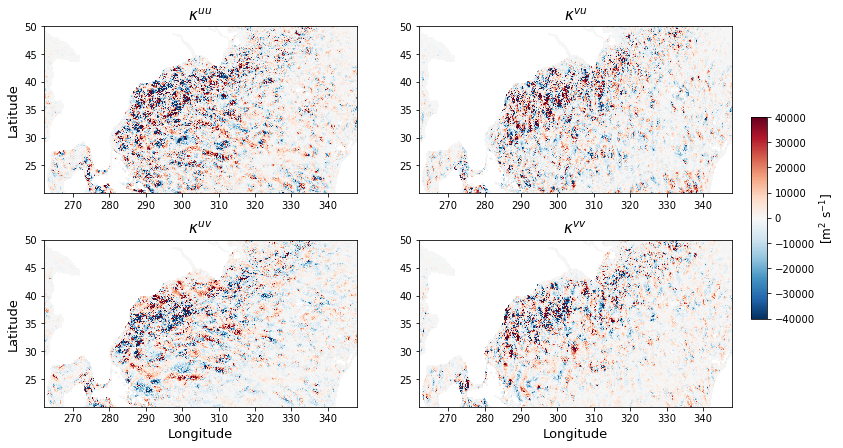

In [25]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           K[:,:,0,0], 
                           vmin=-4e4, vmax=4e4, cmap='RdBu_r', rasterized=True)
im1 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           K[:,:,1,0], 
                           vmin=-4e4, vmax=4e4, cmap='RdBu_r', rasterized=True)
im2 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           K[:,:,0,1], 
                           vmin=-4e4, vmax=4e4, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           K[:,:,1,1], 
                           vmin=-4e4, vmax=4e4, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$\kappa^{uu}$", 
                    fontsize=15)
axes[1,0].set_title(r"$\kappa^{uv}$", 
                    fontsize=15)
axes[0,1].set_title(r"$\kappa^{vu}$", 
                    fontsize=15)
axes[1,1].set_title(r"$\kappa^{vv}$", 
                    fontsize=15)


axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.28) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)


plt.savefig(op.join(ddir,'Figures/K_weight1e3_1963-Dec-26_50.pdf'))

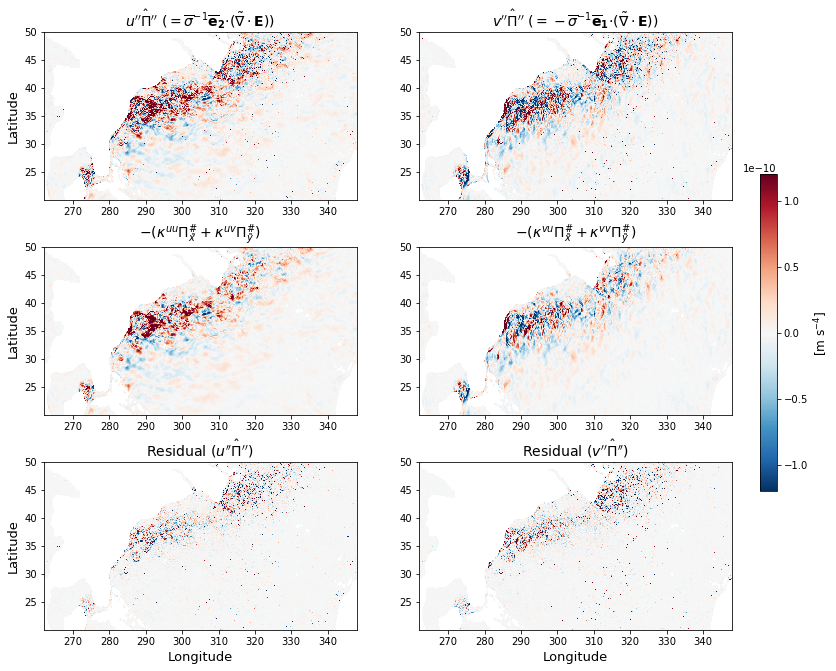

In [26]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           PVpx.sel(YC=slice(yNstart+5,yend+12**-1)).isel(sig=16), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           PVpy.sel(YC=slice(yNstart+5,yend+12**-1)).isel(sig=16), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -(K[:,:,0,0]*PVx.sel(YC=slice(yNstart+5,yend+12**-1))
                             + K[:,:,1,0]*PVy.sel(YC=slice(yNstart+5,yend+12**-1))
                            ), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -(K[:,:,0,1]*PVx.sel(YC=slice(yNstart+5,yend+12**-1))
                             + K[:,:,1,1]*PVy.sel(YC=slice(yNstart+5,yend+12**-1))
                            ), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           PVpx.sel(YC=slice(yNstart+5,yend+12**-1)).isel(sig=16)
                           + (K[:,:,0,0]*PVx.sel(YC=slice(yNstart+5,yend+12**-1))
                              + K[:,:,1,0]*PVy.sel(YC=slice(yNstart+5,yend+12**-1))
                             ), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           PVpy.sel(YC=slice(yNstart+5,yend+12**-1)).isel(sig=16)
                           + (K[:,:,0,1]*PVx.sel(YC=slice(yNstart+5,yend+12**-1))
                              + K[:,:,1,1]*PVy.sel(YC=slice(yNstart+5,yend+12**-1))
                             ),
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].set_title(r"$\hat{u''\Pi''}$ $(= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[0,1].set_title(r"$\hat{v''\Pi''}$ $(= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\Pi^\#_\tilde{x} + \kappa^{uv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\Pi^\#_\tilde{x} + \kappa^{vv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[2,0].set_title(r"Residual $(\hat{u''\Pi''})$", 
                    fontsize=14)
axes[2,1].set_title(r"Residual $(\hat{v''\Pi''})$", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.28) 
cbax0 = fig.add_axes([0.89, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)
# cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
# cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
# cbar2.set_label(r"[m s$^{-4}$]", fontsize=12)
# cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17])
# cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
# cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/PV_param_weight1e3_1963-Dec-26_50.pdf'))

In [13]:
vort_sm = filt(vort.drop_vars('rAz').chunk({'YG':ychunk,'XG':xchunk}
                                          ), nker=np.ones((ny,nx,nb)))
zetaxb_sm = filt(zetaxb, nker=np.ones((ny,nx,nb)))
zetayb_sm = filt(zetayb, nker=np.ones((ny,nx,nb)))
sigmab_sm = filt(sigmab, nker=np.ones((ny,nx,nb)))


vortsm_x = grid.diff(vort_sm*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vortsm_y = grid.diff(vort_sm*grid.interp(ds.dxG,'X'),
                     'Y',boundary='fill') * ds.rAw**-1
vort_x = grid.diff(vort*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vort_y = grid.diff(vort*grid.interp(ds.dxG,'X'),
                   'Y',boundary='fill') * ds.rAw**-1


zetabsm_x = grid.diff(zetaxb_sm,'X')*grid.interp(ds.dxC,'X')**-1
zetabsm_y = (grid.diff(zetayb_sm,'Y',boundary='fill')
             * grid.interp(ds.dyC,'Y',boundary='fill')**-1)
zetab_x = grid.diff(zetaxb,'X')*grid.interp(ds.dxC,'X')**-1
zetab_y = grid.diff(zetayb,'Y',boundary='fill')*grid.interp(ds.dyC,'Y',boundary='fill')**-1


sigmabsm_x = grid.interp(grid.diff(zetabsm_x,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill')
sigmabsm_y = grid.interp(grid.diff(zetabsm_y,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill')
sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')


absvortsm = fC + grid.interp(grid.interp(vort_sm,'X'),'Y',boundary='fill')
Pism_xs = (grid.interp(vortsm_x,'Y',boundary='fill')
           - sigmab_x * sigmab_sm**-1 * absvortsm)
Pism_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
           + grid.interp(vortsm_y,'X')
          ) - sigmab_y * sigmab_sm**-1 * absvortsm
absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
         - sigmab_x * sigmab**-1 * absvort)
Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
         + grid.interp(vort_y,'X')
        ) - sigmab_y * sigmab**-1 * absvort


Pism_x = Pism_xs * sigmab_sm**-1
Pism_y = Pism_ys * sigmab_sm**-1
Pi_x = Pi_xs * sigmab**-1
Pi_y = Pi_ys * sigmab**-1
print(Pi_y,Pi_x)

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 248, 58), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0 <xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 248, 58), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0


In [14]:
that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
that_sm = filt(that, nker=np.ones((ny,nx,nb)))
shat_sm = filt(shat, nker=np.ones((ny,nx,nb)))


thatsm_x = grid.diff(that_sm,'X') * ds.dxC**-1
thatsm_y = grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1
shatsm_x = grid.diff(shat_sm,'X') * ds.dxC**-1
shatsm_y = grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1
that_x = grid.diff(that,'X') * ds.dxC**-1
that_y = grid.diff(that,'Y',boundary='fill') * ds.dyC**-1
shat_x = grid.diff(shat,'X') * ds.dxC**-1
shat_y = grid.diff(shat,'Y',boundary='fill') * ds.dyC**-1


tpp = dsmn.tdz * dsz.dzetaF**-1 - that
spp = dsmn.sdz * dsz.dzetaF**-1 - shat
upptpphat = (upp*grid.interp(tpp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uppspphat = (upp*grid.interp(spp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uptphat_sm = filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
vptphat_sm = filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
upsphat_sm = filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
vpsphat_sm = filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), 
                  nker=np.ones((ny,nx,nb)))


PVpx_sm = filt(PVpx, nker=np.ones((ny,nx,nb)))
PVpy_sm = filt(PVpy, nker=np.ones((ny,nx,nb)))

# print(that_x, that_y, shat_x, shat_y, upptpphat, vpptpphat)
upsphat_sm

<xarray.DataArray '_trim-8fb5640eb6f54779c986193e419a2a74' (YC: 783, XG: 1000, sig: 60)>
dask.array<_trim, shape=(783, 1000, 60), dtype=float64, chunksize=(400, 250, 60), chunktype=numpy.ndarray>
Coordinates:
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947

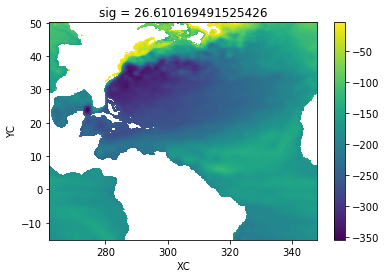

In [16]:
zetab.isel(sig=13).plot()

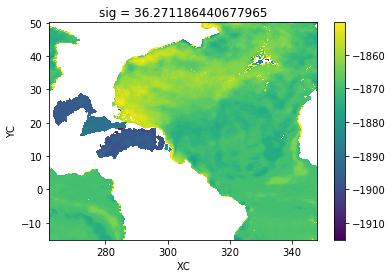

In [19]:
zetab.isel(sig=32).plot()

In [15]:
ut = grid.interp(uptphat_sm.isel(sig=slice(sstart,send)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1))
vt = grid.interp(vptphat_sm.isel(sig=slice(sstart,send)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1))
us = grid.interp(upsphat_sm.isel(sig=slice(sstart,send)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1))
vs = grid.interp(vpsphat_sm.isel(sig=slice(sstart,send)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1))
uPV = PVpx_sm.isel(sig=slice(sstart,send)).sel(YC=slice(yNstart+5,yend+2*12**-1))
vPV = PVpy_sm.isel(sig=slice(sstart,send)).sel(YC=slice(yNstart+5,yend+2*12**-1))

tx = grid.interp(thatsm_x.isel(sig=slice(sstart,send)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1))
ty = grid.interp(thatsm_y.isel(sig=slice(sstart,send)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1))
sx = grid.interp(shatsm_x.isel(sig=slice(sstart,send)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1))
sy = grid.interp(shatsm_y.isel(sig=slice(sstart,send)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1))
PVx = Pism_x.isel(sig=slice(sstart,send)).sel(YC=slice(yNstart+5,yend+2*12**-1))
PVy = Pism_y.isel(sig=slice(sstart,send)).sel(YC=slice(yNstart+5,yend+2*12**-1))
    

##############################
ut_norm = (ut * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1).compute()
vt_norm = (vt * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1).compute()
us_norm = (us * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1).compute()
vs_norm = (vs * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1).compute()
uPV_norm = (uPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1).compute()
vPV_norm = (vPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1).compute()

tx_norm = (tx * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1).compute()
ty_norm = (ty * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1).compute()
sx_norm = (sx * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1).compute()
sy_norm = (sy * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1).compute()
PVx_norm = (PVx * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1).compute()
PVy_norm = (PVy * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1).compute()

In [7]:
itime = 943920
# dsave = ut_norm.to_dataset(name='uptp')
# dsave['vptp'] = vt_norm
# dsave['upsp'] = us_norm
# dsave['vpsp'] = vs_norm
# dsave['upPVp'] = uPV_norm
# dsave['vpPVp'] = vPV_norm
# dsave['tx'] = tx_norm
# dsave['ty'] = ty_norm
# dsave['sx'] = sx_norm
# dsave['sy'] = sy_norm
# dsave['PVx'] = PVx_norm
# dsave['PVy'] = PVy_norm
# dsave.to_netcdf(op.join(ddir,'%4d/Normalized-fluxes_isig%2d-%2d_%010d.nc' 
#                         % (year,sstart,send-1,itime)))
dsflx = xr.open_dataset(op.join(ddir,'%4d/Normalized-fluxes_isig%2d-%2d_%010d.nc' 
                                % (year,sstart,send-1,itime)))
ut_norm = dsflx.uptp
vt_norm = dsflx.vptp
us_norm = dsflx.upsp
vs_norm = dsflx.vpsp
uPV_norm = dsflx.upPVp
vPV_norm = dsflx.vpPVp
tx_norm = dsflx.tx
ty_norm = dsflx.ty
sx_norm = dsflx.sx
sy_norm = dsflx.sy
PVx_norm = dsflx.PVx
PVy_norm = dsflx.PVy
dsflx

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 362, sig: 21)
Coordinates:
  * YC       (YC) float32 20.000034 20.083368 20.1667 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 26.61 27.12 27.63 28.14 ... 35.25 35.76 36.27 36.78
    rA       (YC, XC) float32 ...
    Depth    (YC, XC) float32 ...
    maskInC  (YC, XC) int8 ...
Data variables:
    uptp     (YC, XC, sig) float64 ...
    vptp     (YC, XC, sig) float64 ...
    upsp     (YC, XC, sig) float64 ...
    vpsp     (YC, XC, sig) float64 ...
    upPVp    (YC, XC, sig) float64 ...
    vpPVp    (YC, XC, sig) float64 ...
    tx       (YC, XC, sig) float64 ...
    ty       (YC, XC, sig) float64 ...
    sx       (YC, XC, sig) float64 ...
    sy       (YC, XC, sig) float64 ...
    PVx      (YC, XC, sig) float64 ...
    PVy      (YC, XC, sig) float64 ...

In [ ]:
G = xr.DataArray(np.array([[ tx_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200}), 
                             ty_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200})],
                           [ sx_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200}), 
                             sy_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200})],
                           [PVx_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200}),
                            PVy_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200})]]),
                 dims=['row','col','YC','XC','sig']
                ).transpose('sig','YC','XC','row','col')
# pinvG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
#                      dims=['sig','YC','XC','row','col'])
# pinvG
G

In [9]:
itime = 943920
# m = 10

for l in range(24,send):
    print('l =', l)
    m = l - sstart
    
    K = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                          len(dsz.XC),1,2,2))*np.nan,
                 dims=['YC','XC','sig','col','row'],
                 coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                         'XC':dsz.XC.data,'sig':np.array([dsz.sig.isel(sig=l).data])}
                )
    

    for j in range(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)))):
        if j % 40 == 0:
            print('j =', j)
        for i in range(len(dsz.XC)):

            if i < len(dsz.XC)-1:
                k = i+1
            else:
                k = 0
            rowF  = np.array([ 0, 0, 
                               1, 1,
                               2, 2,
                               3, 3, 
                               4, 4,
                               5, 5,
                               6, 6, 
                               7, 7,
                               8, 8,
                               9, 9,
                              10,10,
                              11,11,
                              12,12,
                              13,13,
                              14,14])
            colF  = np.array([ 0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1])
            dataF = np.array([ ut_norm.isel(YC=j-1,XC=i,sig=m),  vt_norm.isel(YC=j-1,XC=i,sig=m),
                               us_norm.isel(YC=j-1,XC=i,sig=m),  vs_norm.isel(YC=j-1,XC=i,sig=m),
                              uPV_norm.isel(YC=j-1,XC=i,sig=m), vPV_norm.isel(YC=j-1,XC=i,sig=m),
                               ut_norm.isel(YC=j,XC=i,sig=m),    vt_norm.isel(YC=j,XC=i,sig=m),
                               us_norm.isel(YC=j,XC=i,sig=m),    vs_norm.isel(YC=j,XC=i,sig=m),
                              uPV_norm.isel(YC=j,XC=i,sig=m),   vPV_norm.isel(YC=j,XC=i,sig=m),
                               ut_norm.isel(YC=j+1,XC=i,sig=m),  vt_norm.isel(YC=j+1,XC=i,sig=m),
                               us_norm.isel(YC=j+1,XC=i,sig=m),  vs_norm.isel(YC=j+1,XC=i,sig=m),
                              uPV_norm.isel(YC=j+1,XC=i,sig=m), vPV_norm.isel(YC=j+1,XC=i,sig=m),
                               ut_norm.isel(YC=j,XC=i-1,sig=m),  vt_norm.isel(YC=j,XC=i-1,sig=m),
                               us_norm.isel(YC=j,XC=i-1,sig=m),  vs_norm.isel(YC=j,XC=i-1,sig=m),
                              uPV_norm.isel(YC=j,XC=i-1,sig=m), vPV_norm.isel(YC=j,XC=i-1,sig=m),
                               ut_norm.isel(YC=j,XC=k,sig=m),    vt_norm.isel(YC=j,XC=k,sig=m),
                               us_norm.isel(YC=j,XC=k,sig=m),    vs_norm.isel(YC=j,XC=k,sig=m),
                              uPV_norm.isel(YC=j,XC=k,sig=m),   vPV_norm.isel(YC=j,XC=k,sig=m)])
            F = spar.csr_matrix((dataF, (rowF, colF)), shape=(23,2)).toarray()

#################################
            rowG  = np.array([ 0, 0, 1, 1, 2, 2,
                               3, 3, 4, 4, 5, 5,
                               6, 6, 7, 7, 8, 8,
                               9, 9,10,10,11,11,
                              12,12,13,13,14,14,
                              15,15,15, 
                              16,16,16,
                              17,17,17, 
                              18,18,18,
                              19,19,19, 
                              20,20,20,
                              21,21,21, 
                              22,22,22])
            colG  = np.array([ 0, 3, 0, 3, 0, 3,
                               1, 4, 1, 4, 1, 4,
                               2, 5, 2, 5, 2, 5,
                               6, 8, 6, 8, 6, 8,
                               7, 9, 7, 9, 7, 9,
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9,    # B
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9])   # B
            wht = 1e3   # 1e6*1e-4
            Aj_1i = wht*(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Aji = wht*-dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                  + dyU.isel(YC=j,XG=i)**-1
                                                 )
            Aj1i = wht*(dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Bji_1 = wht*(dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1
            Bji = wht*-dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                + dxV.isel(YG=j,XC=i)**-1
                                               )
            Bji1 = wht*(dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1
            dataG = np.array([ -tx_norm.isel(YC=j-1,XC=i,sig=m),  -ty_norm.isel(YC=j-1,XC=i,sig=m),
                               -sx_norm.isel(YC=j-1,XC=i,sig=m),  -sy_norm.isel(YC=j-1,XC=i,sig=m),
                              -PVx_norm.isel(YC=j-1,XC=i,sig=m), -PVy_norm.isel(YC=j-1,XC=i,sig=m),
                               -tx_norm.isel(YC=j,XC=i,sig=m),    -ty_norm.isel(YC=j,XC=i,sig=m),
                               -sx_norm.isel(YC=j,XC=i,sig=m),    -sy_norm.isel(YC=j,XC=i,sig=m),
                              -PVx_norm.isel(YC=j,XC=i,sig=m),   -PVy_norm.isel(YC=j,XC=i,sig=m),
                               -tx_norm.isel(YC=j+1,XC=i,sig=m),  -ty_norm.isel(YC=j+1,XC=i,sig=m),
                               -sx_norm.isel(YC=j+1,XC=i,sig=m),  -sy_norm.isel(YC=j+1,XC=i,sig=m),
                              -PVx_norm.isel(YC=j+1,XC=i,sig=m), -PVy_norm.isel(YC=j+1,XC=i,sig=m),
                               -tx_norm.isel(YC=j,XC=i-1,sig=m),  -ty_norm.isel(YC=j,XC=i-1,sig=m),
                               -sx_norm.isel(YC=j,XC=i-1,sig=m),  -sy_norm.isel(YC=j,XC=i-1,sig=m),
                              -PVx_norm.isel(YC=j,XC=i-1,sig=m), -PVy_norm.isel(YC=j,XC=i-1,sig=m),
                               -tx_norm.isel(YC=j,XC=k,sig=m),    -ty_norm.isel(YC=j,XC=k,sig=m),
                               -sx_norm.isel(YC=j,XC=k,sig=m),    -sy_norm.isel(YC=j,XC=k,sig=m),
                              -PVx_norm.isel(YC=j,XC=k,sig=m),   -PVy_norm.isel(YC=j,XC=k,sig=m),
####################################                          
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1,
####################################
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1])
            G = spar.csr_matrix((dataG, (rowG, colG)), shape=(23,10)).toarray()
            
#################################
            if ~(np.isnan(F).any() or np.isnan(G).any()):
                tmp = np.linalg.pinv(G).dot(F)
                K.isel(YC=j,XC=i,sig=0)[0,0] = tmp[1,0]
                K.isel(YC=j,XC=i,sig=0)[1,0] = tmp[4,0]
                K.isel(YC=j,XC=i,sig=0)[0,1] = tmp[1,1]
                K.isel(YC=j,XC=i,sig=0)[1,1] = tmp[4,1]

                
#     m += 1
    
    K.to_dataset(name='K').to_netcdf(op.join(ddir,'%4d/Diff-tensor_isig%2d_%010d.nc' 
                                             % (year,l,itime)))

l = 24
j = 0


NameError: name 'dyU' is not defined

In [11]:
itime = 943920
# m = 10
nskip = 3

K = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                          len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip]),
                          len(dsz.XC[::nskip]),2,2))*np.nan,
                 dims=['sig','YC','XC','col','row'],
                 coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data,
                         'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip].data,
                         'XC':dsz.XC[::nskip].data}
                )
dxT = grid.interp(ds.dxG,'Y',boundary='fill'
                 ).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyT = grid.interp(ds.dyG,'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyU = ds.dyG.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dxV = ds.dxG.sel(YG=slice(yNstart+5,yend+2*12**-1)).load()
print(dxT.shape, dyT.shape, dyU.shape, dxV.shape)
    

for j in np.arange(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),dtype=int)[::nskip]:
    y = dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).isel(YC=j).data
    if j % 10 == 0:
        print('j =', j)
        start = time.time()
        
    for i in np.arange(len(dsz.XC),dtype=int)[::nskip]:
        x = dsz.XC.isel(XC=i).data
        if i < len(dsz.XC)-1:
            k = i+1
        else:
            k = 0
        
        F = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                                  23,2))*np.nan,
                         dims=['sig','row','col'],
                         coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data})
        G = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                                  23,10))*np.nan,
                         dims=['sig','row','col'],
                         coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data})
        
        for l in range(len(F.sig)):
            rowF  = np.array([ 0, 0, 
                               1, 1,
                               2, 2,
                               3, 3, 
                               4, 4,
                               5, 5,
                               6, 6, 
                               7, 7,
                               8, 8,
                               9, 9,
                              10,10,
                              11,11,
                              12,12,
                              13,13,
                              14,14])
            colF  = np.array([ 0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1])
            dataF = np.array([ ut_norm.isel(YC=j-1,XC=i,sig=l),  vt_norm.isel(YC=j-1,XC=i,sig=l),
                               us_norm.isel(YC=j-1,XC=i,sig=l),  vs_norm.isel(YC=j-1,XC=i,sig=l),
                              uPV_norm.isel(YC=j-1,XC=i,sig=l), vPV_norm.isel(YC=j-1,XC=i,sig=l),
                               ut_norm.isel(YC=j,XC=i,sig=l),    vt_norm.isel(YC=j,XC=i,sig=l),
                               us_norm.isel(YC=j,XC=i,sig=l),    vs_norm.isel(YC=j,XC=i,sig=l),
                              uPV_norm.isel(YC=j,XC=i,sig=l),   vPV_norm.isel(YC=j,XC=i,sig=l),
                               ut_norm.isel(YC=j+1,XC=i,sig=l),  vt_norm.isel(YC=j+1,XC=i,sig=l),
                               us_norm.isel(YC=j+1,XC=i,sig=l),  vs_norm.isel(YC=j+1,XC=i,sig=l),
                              uPV_norm.isel(YC=j+1,XC=i,sig=l), vPV_norm.isel(YC=j+1,XC=i,sig=l),
                               ut_norm.isel(YC=j,XC=i-1,sig=l),  vt_norm.isel(YC=j,XC=i-1,sig=l),
                               us_norm.isel(YC=j,XC=i-1,sig=l),  vs_norm.isel(YC=j,XC=i-1,sig=l),
                              uPV_norm.isel(YC=j,XC=i-1,sig=l), vPV_norm.isel(YC=j,XC=i-1,sig=l),
                               ut_norm.isel(YC=j,XC=k,sig=l),    vt_norm.isel(YC=j,XC=k,sig=l),
                               us_norm.isel(YC=j,XC=k,sig=l),    vs_norm.isel(YC=j,XC=k,sig=l),
                              uPV_norm.isel(YC=j,XC=k,sig=l),   vPV_norm.isel(YC=j,XC=k,sig=l)])
            F.isel(sig=l)[:] = spar.csr_matrix((dataF, (rowF, colF)), shape=(23,2)).toarray()

#################################
            rowG  = np.array([ 0, 0, 1, 1, 2, 2,
                               3, 3, 4, 4, 5, 5,
                               6, 6, 7, 7, 8, 8,
                               9, 9,10,10,11,11,
                              12,12,13,13,14,14,
                              15,15,15, 
                              16,16,16,
                              17,17,17, 
                              18,18,18,
                              19,19,19, 
                              20,20,20,
                              21,21,21, 
                              22,22,22])
            colG  = np.array([ 0, 3, 0, 3, 0, 3,
                               1, 4, 1, 4, 1, 4,
                               2, 5, 2, 5, 2, 5,
                               6, 8, 6, 8, 6, 8,
                               7, 9, 7, 9, 7, 9,
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9,    # B
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9])   # B
            wht = 1e3   # 1e6*1e-3
            Aj_1i = wht*(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Aji = wht*-dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                  + dyU.isel(YC=j,XG=i)**-1
                                                 )
            Aj1i = wht*(dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Bji_1 = wht*(dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1
            Bji = wht*-dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                + dxV.isel(YG=j,XC=i)**-1
                                               )
            Bji1 = wht*(dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1
            dataG = np.array([ -tx_norm.isel(YC=j-1,XC=i,sig=l), -ty_norm.isel(YC=j-1,XC=i,sig=l),
                               -sx_norm.isel(YC=j-1,XC=i,sig=l), -sy_norm.isel(YC=j-1,XC=i,sig=l),
                              -PVx_norm.isel(YC=j-1,XC=i,sig=l),-PVy_norm.isel(YC=j-1,XC=i,sig=l),
                               -tx_norm.isel(YC=j,XC=i,sig=l),   -ty_norm.isel(YC=j,XC=i,sig=l),
                               -sx_norm.isel(YC=j,XC=i,sig=l),   -sy_norm.isel(YC=j,XC=i,sig=l),
                              -PVx_norm.isel(YC=j,XC=i,sig=l),  -PVy_norm.isel(YC=j,XC=i,sig=l),
                               -tx_norm.isel(YC=j+1,XC=i,sig=l), -ty_norm.isel(YC=j+1,XC=i,sig=l),
                               -sx_norm.isel(YC=j+1,XC=i,sig=l), -sy_norm.isel(YC=j+1,XC=i,sig=l),
                              -PVx_norm.isel(YC=j+1,XC=i,sig=l),-PVy_norm.isel(YC=j+1,XC=i,sig=l),
                               -tx_norm.isel(YC=j,XC=i-1,sig=l), -ty_norm.isel(YC=j,XC=i-1,sig=l),
                               -sx_norm.isel(YC=j,XC=i-1,sig=l), -sy_norm.isel(YC=j,XC=i-1,sig=l),
                              -PVx_norm.isel(YC=j,XC=i-1,sig=l),-PVy_norm.isel(YC=j,XC=i-1,sig=l),
                               -tx_norm.isel(YC=j,XC=k,sig=l),   -ty_norm.isel(YC=j,XC=k,sig=l),
                               -sx_norm.isel(YC=j,XC=k,sig=l),   -sy_norm.isel(YC=j,XC=k,sig=l),
                              -PVx_norm.isel(YC=j,XC=k,sig=l),  -PVy_norm.isel(YC=j,XC=k,sig=l),
####################################                          
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1,
####################################
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1])
            G.isel(sig=l)[:] = spar.csr_matrix((dataG, (rowG, colG)), shape=(23,10)).toarray()
            
#################################
        if ~(np.isnan(F).any() or np.isnan(G).any()):
#                 tmp = np.linalg.pinv(G).dot(F)
#                 K.isel(YC=j,XC=i,sig=0)[0,0] = tmp[1,0]
#                 K.isel(YC=j,XC=i,sig=0)[1,0] = tmp[4,0]
#                 K.isel(YC=j,XC=i,sig=0)[0,1] = tmp[1,1]
#                 K.isel(YC=j,XC=i,sig=0)[1,1] = tmp[4,1]
            invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                                G.chunk({'sig':1}).data).compute(),
                                dims=['sig','row','col'])
            for m in range(len(F.sig)):
                tmp = invG.isel(sig=m).data.dot(F.isel(sig=m).data)
#                 K.sel(YC=y,XC=x).isel(sig=m)[0,0] = tmp[1,0]
#                 K.sel(YC=y,XC=x).isel(sig=m)[1,0] = tmp[4,0]
#                 K.sel(YC=y,XC=x).isel(sig=m)[0,1] = tmp[1,1]
#                 K.sel(YC=y,XC=x).isel(sig=m)[1,1] = tmp[4,1]
                K.sel(YC=y,XC=x).isel(sig=m)[:] = np.array([[tmp[1,0],tmp[1,1]],
                                                            [tmp[4,0],tmp[4,1]]])
    
    if j % 10 == 0:
        end = time.time()
        print('Lapse time =', end-start)
#     m += 1

K.to_dataset(name='K').to_netcdf(op.join(ddir,'%4d/Diff-tensor_isig%2d-%2d_nskip%1d_%010d.nc' 
                                 % (year,sstart,send-1,nskip,itime)))

(362, 1000) (362, 1000) (362, 1000) (362, 1000)
j = 0
Lapse time = 697.1547784805298


KeyboardInterrupt: 

In [ ]:
# m = 10
# F = xr.DataArray(np.array([[ ut_norm, 
#                              vt_norm ],
#                            [ us_norm, 
#                              vs_norm ],
#                            [uPV_norm,
#                             vPV_norm ]]),
#                  dims=['row','col','YC','XC','sig']
#                 ).transpose('sig','YC','XC','row','col')
# G = xr.DataArray(np.array([[ tx_norm, 
#                              ty_norm ],
#                            [ sx_norm, 
#                              sy_norm ],
#                            [PVx_norm,
#                             PVy_norm ]]),
#                  dims=['row','col','YC','XC','sig']
#                 ).chunk({'sig':1,'YC':1,'XC':1}).transpose('sig','YC','XC','row','col')
# # G
# pinvG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
#                      dims=['sig','YC','XC','row','col'])
# pinvG

In [16]:
itime = 943920
nskip = 3

K = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                          len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip]),
                          len(dsz.XC[::nskip]),2,2))*np.nan,
                 dims=['sig','YC','XC','row','col'],
                 coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data,
                         'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip].data,
                         'XC':dsz.XC[::nskip].data}
                )

nchk = 20
for y in dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip][::nchk].data:
#     y = dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).isel(YC=j).data
#     if j % 10 == 0:
    print('YC =', y)
    start = time.time()
        
    for x in dsz.XC[::nskip][::nchk].data:
#         x = dsz.XC.isel(XC=i).data
        
        G = xr.DataArray(np.array([[ tx_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1)), 
                                     ty_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1))],
                                   [ sx_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1)), 
                                     sy_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1))],
                                   [PVx_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1)),
                                    PVy_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1))]
                                  ]),
                         dims=['row','col','YC','XC','sig']
                        ).chunk({'sig':1,'YC':1,'XC':1}
                               ).transpose('sig','YC','XC','row','col')
        pinvG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
                             dims=['sig','YC','XC','row','col'],
                             coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data,
                                     'YC':dsz.YC.sel(YC=slice(y,y+nskip*nchk*12**-1))[::nskip].data,
                                     'XC':dsz.XC.sel(XC=slice(x,x+nskip*nchk*12**-1))[::nskip].data}
                            )
        
        for l in dsz.YC.sel(YC=slice(y,y+nskip*nchk*12**-1))[::nskip].data:
            for m in dsz.XC.sel(XC=slice(x,x+nskip*nchk*12**-1))[::nskip].data:
                for n in K.sig.data:
                    F = np.array([[ ut_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n), 
                                    vt_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n)],
                                  [ us_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n), 
                                    vs_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n)],
                                  [uPV_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n),
                                   vPV_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n)]
                                 ])

                    if ~(np.isnan(F).any() or np.isnan(pinvG.sel(YC=l,XC=m,sig=n)).any()):
#                         tmp = pinvG.isel(YC=l,XC=m,sig=n).data.dot(F)
#                         K.sel(YC=y,XC=x).isel(sig=m)[0,0] = tmp[1,0]
#                         K.sel(YC=y,XC=x).isel(sig=m)[1,0] = tmp[4,0]
#                         K.sel(YC=y,XC=x).isel(sig=m)[0,1] = tmp[1,1]
#                         K.sel(YC=y,XC=x).isel(sig=m)[1,1] = tmp[4,1]
                        K.sel(YC=l,XC=m,sig=n)[:] = pinvG.sel(YC=l,XC=m,sig=n).data.dot(F)
    
#     if j % 10 == 0:
    end = time.time()
    print('Lapse time =', end-start)
#     m += 1

K.to_dataset(name='K').to_netcdf(op.join(ddir,'%4d/Diff-tensor_isig%2d-%2d_nskip%1d_%010d.nc' 
                                 % (year,sstart,send-1,nskip,itime)))
K

YC = 20.000034
Lapse time = 3577.5203096866608
YC = 25.000034
Lapse time = 3515.4153678417206
YC = 30.000034
Lapse time = 3416.412320613861
YC = 35.000034
Lapse time = 3373.7181804180145
YC = 40.000034
Lapse time = 3405.0946419239044
YC = 45.000034
Lapse time = 3316.9147753715515
YC = 50.000034
Lapse time = 159.46019792556763


<xarray.DataArray (sig: 21, YC: 121, XC: 334, row: 2, col: 2)>
array([[[[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[            nan,             nan],
          [            nan,             nan]],

         [[-6.61116049e+02,  8.15336297e+02],
          [-5.10156225e+03,  4.56123324e+03]],

         [[-2.56689790e+03,  1.37084117e+03],
          [ 7.19039094e+02, -7.19862434e+01]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[-5.83546307e+03,  2.88328464e+03],
          [-1.69524379e+04,  1.40167299e+04]],

         [[-3.90358114e+00,  2.57892913e+03],
          [-2.35649698e+03,  4.57069145e+03]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[ 8.43584897e+03, -1.14004462e+04],
          [ 1.80724484e+04, -1.92132155e+04]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]]],



       [[[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan

In [ ]:
nremap = 90

for year in range(1966,1968):
    if year == 1963:
        ntimes = np.arange( 943920    , 943920+dnf,dnf,dtype=int)
        ystart = ySstart
    else:
        ystart = yNstart
        if year == 1964:
            ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
        elif year == 1965:
            ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
        elif year == 1966:
            ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
        else:
            ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
        
    for itime in ntimes:

    #     dsmn = xr.open_dataset(op.join(ddir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
    #                                    % (year,nremap,itime))
    #                           ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
    #                                    'XC':xchunk,'XG':xchunk,
    #                                    'YC':ychunk,'YG':ychunk})
    #     dsz = xr.open_dataset(op.join(ddir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
    #                                   % (year,nremap,itime))
    #                          ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
    #                                   'XC':xchunk,'XG':xchunk,
    #                                   'YC':ychunk,'YG':ychunk})
    #     dsdiv = xr.open_dataset(op.join(ddir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                                     % (year,nremap,itime))
    #                            ).chunk({'sig':schunk,'sigp1':schunk,
    #                                     'XC':xchunk,'XG':xchunk,
    #                                     'YC':ychunk,'YG':ychunk})
        dsmn = xr.open_zarr(op.join(ddir,'%4d/Dyns/%7d' % (year,itime)))
        dsz = xr.open_zarr(op.join(ddir,'%4d/Zs/%7d' % (year,itime)))
        dsdiv = xr.open_zarr(op.join(ddir,'%4d/E-P/%7d' % (year,itime)))

        grid = Grid(dsz, periodic=['X'], 
                    coords={'Z':{'center':'sig','outer':'sigp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )

        start = time.time()
        fC = xr.apply_ufunc(gsw.f, dsz.YC)
        fG = xr.apply_ufunc(gsw.f, dsz.YG)
        buoyb = -grav * dsmn.sig * rhoConst**-1
        buoybp1 = -grav * dsmn.sigp1 * rhoConst**-1
        sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

        sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
                  * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                 )
        sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )

        e00_x = dsdiv.e00x
        e10_y = dsdiv.e10y
        e20_b = dsdiv.e20b
        e01_x = dsdiv.e01x
        e11_y = dsdiv.e11y
        e21_b = dsdiv.e21b
        Eu = e00_x + e10_y + e20_b
        Ev = e01_x + e11_y + e21_b

    ##############################
        that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
        shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
        vhat = dsmn.vdz.mean('nmemb',skipna=True) * dsz.dzetaFy.mean('nmemb',skipna=True)**-1
        uhat = dsmn.udz.mean('nmemb',skipna=True) * dsz.dzetaFx.mean('nmemb',skipna=True)**-1
        vort = (grid.diff(vhat*ds.dyC,'X') 
                - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
               ) * ds.rAz**-1 
        Pi = (grid.interp(grid.interp(vort,'X'),'Y',boundary='fill') 
              + fC) * sigmab**-1

        vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
        upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
        tpp = dsmn.tdz * dsz.dzetaF**-1 - that
        spp = dsmn.sdz * dsz.dzetaF**-1 - shat
        upptpphat = (upp*grid.interp(tpp,'X')
                     * sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
        vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
                     * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
        uppspphat = (upp*grid.interp(spp,'X')
                     * sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
        vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
                     * sigmay).mean('nmemb',skipna=True) * sigmayb**-1

        PVpx = sigmab**-1 * Ev
        PVpy = -sigmab**-1 * Eu

    ##############################
    ##############################  
        that_sm = _filt(that)
        shat_sm = _filt(shat)
        Pi_sm = _filt(Pi.chunk({'YC':ychunk,'XC':xchunk}))

        thatsm_x = grid.diff(that_sm,'X') * ds.dxC**-1
        thatsm_y = grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1
        shatsm_x = grid.diff(shat_sm,'X') * ds.dxC**-1
        shatsm_y = grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1
        Pism_x = grid.diff(Pi_sm,'X') * ds.dxC**-1
        Pism_y = grid.diff(Pi_sm,'Y',boundary='fill') * ds.dyC**-1

        uptphat_sm = _filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), 
                           dim=['YC','XG'])
        vptphat_sm = _filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), 
                           dim=['YG','XC'])
        upsphat_sm = _filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), 
                           dim=['YC','XG'])
        vpsphat_sm = _filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), 
                           dim=['YG','XC'])

        PVpx_sm = _filt(PVpx)
        PVpy_sm = _filt(PVpy)

    ##############################
        ut = grid.interp(uptphat_sm.isel(sig=slice(sstart,send)),
                         'X').sel(YC=slice(ystart+5,yend+2*12**-1))
        vt = grid.interp(vptphat_sm.isel(sig=slice(sstart,send)),
                         'Y',boundary='fill').sel(YC=slice(ystart+5,yend+2*12**-1))
        us = grid.interp(upsphat_sm.isel(sig=slice(sstart,send)),
                         'X').sel(YC=slice(ystart+5,yend+2*12**-1))
        vs = grid.interp(vpsphat_sm.isel(sig=slice(sstart,send)),
                         'Y',boundary='fill').sel(YC=slice(ystart+5,yend+2*12**-1))
        uPV = PVpx_sm.isel(sig=slice(sstart,send)).sel(YC=slice(ystart+5,yend+2*12**-1))
        vPV = PVpy_sm.isel(sig=slice(sstart,send)).sel(YC=slice(ystart+5,yend+2*12**-1))

        tx = grid.interp(thatsm_x.isel(sig=slice(sstart,send)),
                         'X').sel(YC=slice(ystart+5,yend+2*12**-1))
        ty = grid.interp(thatsm_y.isel(sig=slice(sstart,send)),
                         'Y',boundary='fill').sel(YC=slice(ystart+5,yend+2*12**-1))
        sx = grid.interp(shatsm_x.isel(sig=slice(sstart,send)),
                         'X').sel(YC=slice(ystart+5,yend+2*12**-1))
        sy = grid.interp(shatsm_y.isel(sig=slice(sstart,send)),
                         'Y',boundary='fill').sel(YC=slice(ystart+5,yend+2*12**-1))
        PVx = grid.interp(Pism_x.isel(sig=slice(sstart,send)),
                          'X').sel(YC=slice(ystart+5,yend+2*12**-1))
        PVy = grid.interp(Pism_y.isel(sig=slice(sstart,send)),
                          'Y',boundary='fill').sel(YC=slice(ystart+5,yend+2*12**-1))

    ##############################
        ut_norm = (ut * np.nanmedian(np.sqrt(ut**2 + vt**2),
                                     axis=(0,1))**-1).compute()
        vt_norm = (vt * np.nanmedian(np.sqrt(ut**2 + vt**2),
                                     axis=(0,1))**-1).compute()
        us_norm = (us * np.nanmedian(np.sqrt(us**2 + vs**2),
                                     axis=(0,1))**-1).compute()
        vs_norm = (vs * np.nanmedian(np.sqrt(us**2 + vs**2),
                                     axis=(0,1))**-1).compute()
        uPV_norm = (uPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                                       axis=(0,1))**-1).compute()
        vPV_norm = (vPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                                       axis=(0,1))**-1).compute()

        tx_norm = (tx * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                                     axis=(0,1))**-1).compute()
        ty_norm = (ty * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                                     axis=(0,1))**-1).compute()
        sx_norm = (sx * np.nanmedian(np.sqrt(us**2 + vs**2),
                                     axis=(0,1))**-1).compute()
        sy_norm = (sy * np.nanmedian(np.sqrt(us**2 + vs**2),
                                     axis=(0,1))**-1).compute()
        PVx_norm = (PVx * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                                       axis=(0,1))**-1).compute()
        PVy_norm = (PVy * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                                       axis=(0,1))**-1).compute()

        end = time.time()
        print('Lapse time filtering:', end-start)

    ##############################
    ##############################
        dsave = ut_norm.to_dataset(name='uptp')
        dsave['vptp'] = vt_norm
        dsave['upsp'] = us_norm
        dsave['vpsp'] = vs_norm
        dsave['upPVp'] = uPV_norm
        dsave['vpPVp'] = vPV_norm
        dsave['tx'] = tx_norm
        dsave['ty'] = ty_norm
        dsave['sx'] = sx_norm
        dsave['sy'] = sy_norm
        dsave['PVx'] = PVx_norm
        dsave['PVy'] = PVy_norm
    #     dsave.to_netcdf(op.join(ddir,
    #                         '%4d/Normalized-fluxes_isig%2d-%2d_Hann_no-smoothness_%010d.nc' 
    #                             % (year,sstart,send-1,itime)))
        dsave.to_zarr(op.join(ddir,'%4d/Norm-fluxes/%7d' % (year,itime)))
        dsave.close()

        del ut_norm, vt_norm, us_norm, vs_norm, uPV_norm, vPV_norm
        del tx_norm, ty_norm, sx_norm, sy_norm, PVx_norm, PVy_norm
        dsdiv.close()
        dsmn.close()
        dsz.close()

        print(itime)

    # client.restart()

Lapse time filtering: 716.578578710556
1546560
Lapse time filtering: 803.6433064937592
1548720


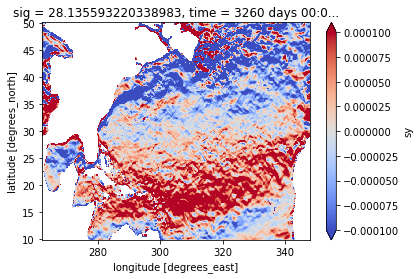

In [5]:
dss = xr.open_dataset(op.join(ddir,'%4d/Normalized-fluxes_isig%2d-%2d_Hann_no-smoothness_%010d.nc' 
                              % (1966,sstart,send-1,1408320)))
dss.sy.isel(sig=3).plot(vmax=1e-4, cmap='coolwarm')